In [67]:
#!g1.1
%pip install -r requirements.txt
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import umap

%matplotlib inline

In [2]:
#!g1.4
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 32
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
dataset_train = dl.FontsDataset(test=False, download=True)
dataset_test = dl.FontsDataset(test=True)

In [4]:
train_dataloader = DataLoader(dataset_train, batch_size=512, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=256, shuffle=True, num_workers=0)

('five', '!the_black_bloc-bold')


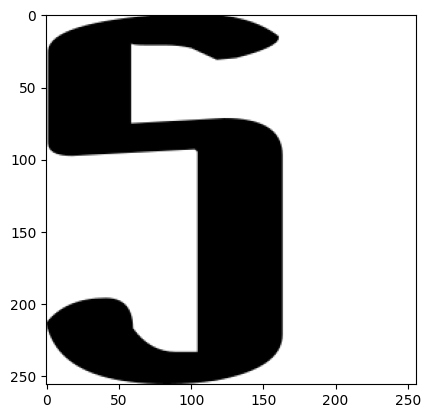

In [5]:
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray):
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    plt.imshow(img)
    
print(dataset_test[0][1:])
save_sampled(dataset_test[0][0], 'test_print.svg')
show_sampled(dataset_test[0][0])

## Определение рисователя прогресса

In [6]:
class Progresser:
    def __init__(self, _train_dataloader, split_num=4):
        self.epoch = 0
        self.train_ts, self.train_loss = [], []
        self.test_ts, self.test_loss = [], []
        self.interval = len(_train_dataloader) // split_num

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None):
        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        last_size = 0.5

        for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')
        last_train = str(self.train_loss[-1]) if len(self.train_loss) > 0 else ''
        last_test = str(self.test_loss[-1]) if len(self.test_loss) > 0 else ''

        ax1.plot(self.train_ts, self.train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
        ax1.plot(self.test_ts, self.test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')

        ax2.plot(
            self.train_ts[-int(len(self.train_ts)*last_size):], 
            self.train_loss[-int(len(self.train_loss)*last_size):], 
            c='darkblue', lw=3, label=f'train: {last_train}',
        )
        ax2.plot(
            self.test_ts[-int(len(self.test_ts)*last_size):], 
            self.test_loss[-int(len(self.test_loss)*last_size):], 
            c='green', marker='o', lw=5, label=f'test: {last_test}'
        )

        ax1.legend()
        ax2.legend()
        if save_to is None:
            plt.show() 
        else:
            plt.savefig(save_to)
            plt.show()
            plt.close()
    
    def add_train(self, ts, loss):
        self.train_ts.append(ts)
        self.train_loss.append(loss)

    def add_test(self, ts, loss):
        self.test_ts.append(ts)
        self.test_loss.append(loss)
        
    def reset(self):
        self.train_ts = []
        self.test_ts = []
        self.train_loss = []
        self.test_loss = []
        self.epoch = 0


progresser = Progresser(train_dataloader)

## Автоэнкодер

In [7]:
class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.layer(x)


class AE(nn.Module):
    activation = nn.Tanh

    def __init__(self, params, line_size):
        super().__init__()
        self.line_size = line_size
        
        encoder_params = params[:]
        
        decoder_params = params[::-1]

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1]))

        self.decoder = []
        for i in range(len(decoder_params) - 1):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def encode(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        return x

    def decode(self, z):
        z = self.decoder(z)
        z = z.view(z.shape[0], -1, self.line_size)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
        
    def loss(self, x_hat, x):
        mse = F.mse_loss(x_hat, x, reduction='sum')
        return mse / x.shape[0]
    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (images, _, _) in enumerate(dataloader):
            images = torch.Tensor(images).to(device)

            output = self(images)
            loss = self.loss(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        tmp_test_loss = []
        for images, _, _ in dataloader:
            images = torch.Tensor(images).to(device)
            
            result = self(images)
            loss = self.loss(result, images)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)

## Вспомогательные функции

In [8]:
def to_numpy(d):
    return d.cpu().detach().numpy()


ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}


def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()


def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)


def run(model, train_dl, test_dl, optimizer, scheduler, epochs, params, _epoch=0, run_name=None, trial=None, save=True):
    class_name = model.__class__.__name__
    if run_name is None:
        run_name = f'{class_name}_{SVG.ENCODE_HEIGHT}_{",".join(map(str, params))}'

    save_folder = Path('models') / class_name / run_name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    max_epoch = progresser.epoch + epochs

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, train_dl, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, test_dl, show=True)
        
        if save:
            torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})
        if _epoch == 1:
            if progresser.test_loss[-1] > progresser.test_loss[-2]:
                return


def setup_ae(params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
    if line_size is None:
        raise Exception('line_size should be provided')
    model = AE(params, line_size).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

    return model, optimizer, scheduler


## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db_full.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 7e-6, 8e-4, log=True)
    p0 = trial.suggest_int('p0', 1600, 4500)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0]
    latent_size = 256

    for i in range(1, 5):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    # step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_ae(
        params=params,
        lr=lr,
        weight_decay=3e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=0.95,
    )
    run(
        model=model, 
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=15,
        params=params,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db_ae.sqlite3",
    study_name="ae_lr,6layers,15epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=4 show_progress_bar=True)

## Создание и запуск AE

Loaded from file


AE(
  (encoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_features=352, out_features=2467, bias=True)
        (1): Tanh()
      )
    )
    (1): Block(
      (layer): Sequential(
        (0): Linear(in_features=2467, out_features=1775, bias=True)
        (1): Tanh()
      )
    )
    (2): Block(
      (layer): Sequential(
        (0): Linear(in_features=1775, out_features=862, bias=True)
        (1): Tanh()
      )
    )
    (3): Block(
      (layer): Sequential(
        (0): Linear(in_features=862, out_features=755, bias=True)
        (1): Tanh()
      )
    )
    (4): Block(
      (layer): Sequential(
        (0): Linear(in_features=755, out_features=657, bias=True)
        (1): Tanh()
      )
    )
    (5): Block(
      (layer): Sequential(
        (0): Linear(in_features=657, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (decoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_features=256, 

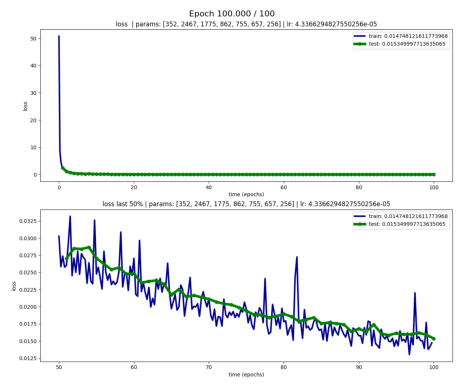

In [9]:
#!g1.4
GLIPH_WIDTH = 256
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 2467, 1775, 862, 755, 657, GLIPH_WIDTH]

# lr = 9e-5
lr = 1e-4

model_ae_path = f'models/AE/AE_{SVG.ENCODE_HEIGHT}_{",".join(map(str,params))}/ckpt.pt'
model_ae, optimizer, scheduler = setup_ae(
    params=params,
    lr=lr,
    weight_decay=4e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=3,
    step_gamma=0.975,
)
if Path(model_ae_path).exists():
    print('Loaded from file')
    model_ae.load_state_dict(torch.load(model_ae_path))
    img = mpimg.imread(str(Path(model_ae_path).parent / '_loss.png'))
    plt.axis('off')
    plt.imshow(img)
else:
    print('Created new')
model_ae

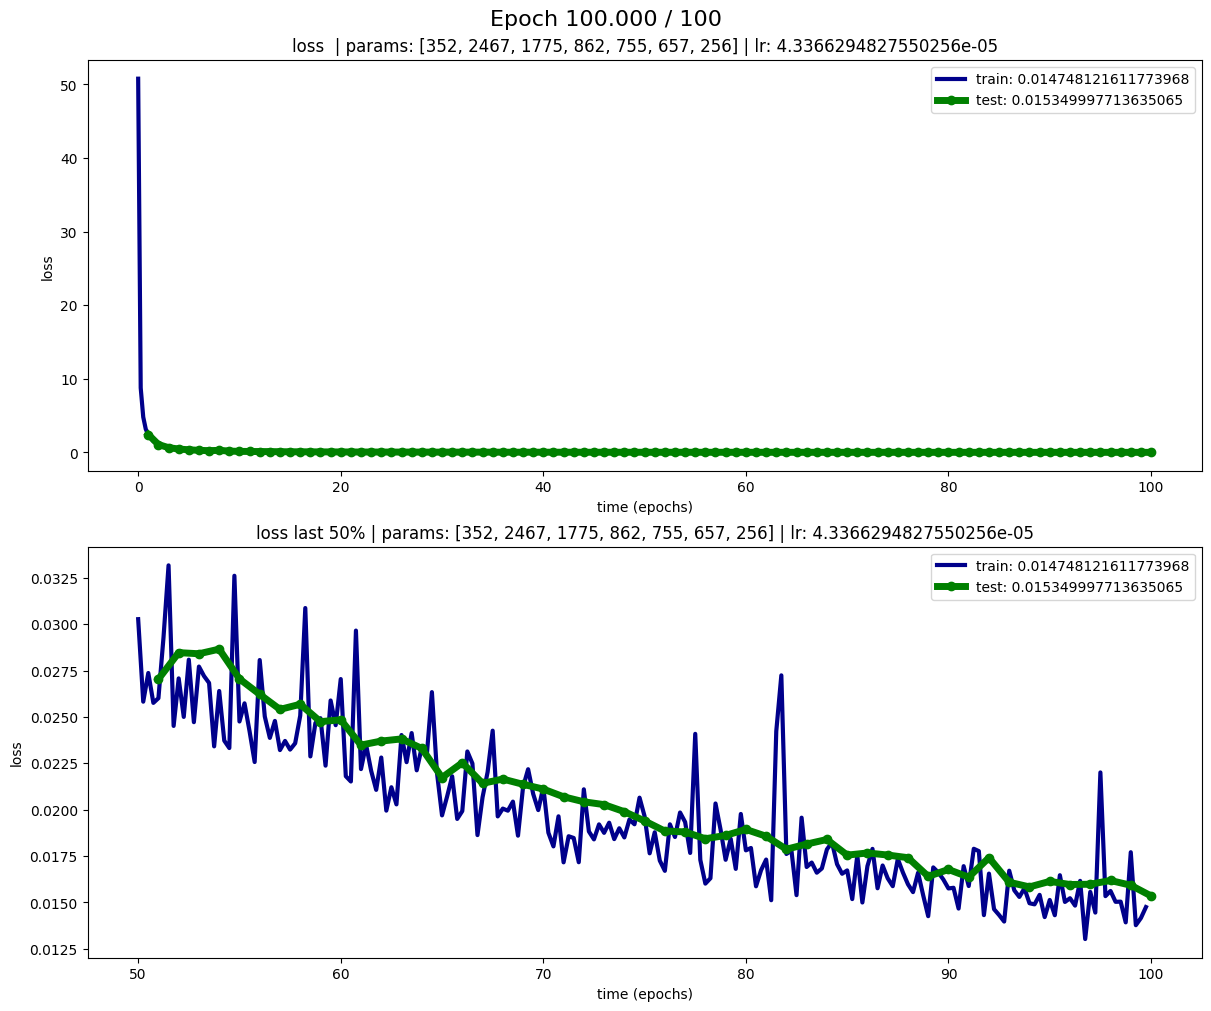

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [1:38:26<00:00, 65.63s/it]


In [11]:
#!g1.4
run(
    model=model_ae,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=90,
    params=params,
)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_14216\2562838483.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


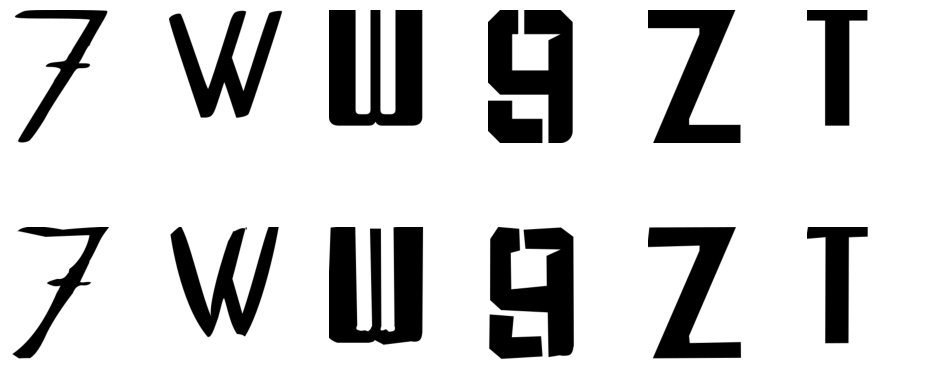

In [12]:
imgs_num = 6
plt.figure(figsize=(2 * imgs_num, 8))
plt.axis('off')

samples, _, _ = dataset_train[400*imgs_num:(400 + 100)*imgs_num: 100]
model_ae.eval()
processed_samples = to_numpy(model_ae(torch.Tensor(samples).to(device)))

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    show_sampled(processed_samples[i])
plt.show()

In [13]:
def decode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.decode(d)

def encode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.encode(d)

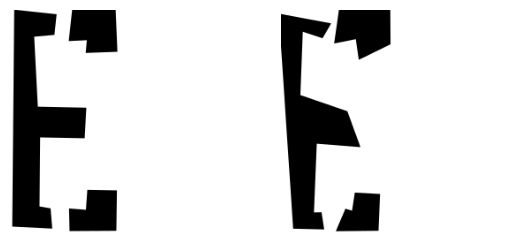

In [15]:
sample, _, _ = dataset_train[2 * 3]

sample = torch.Tensor(sample.reshape((1, -1))).to(device)

sp = encode_img(sample)

plt.subplot(1, 2, 1)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))

shift = torch.randn_like(sp) * 0.01

sp += shift

plt.subplot(1, 2, 2)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))
plt.show()

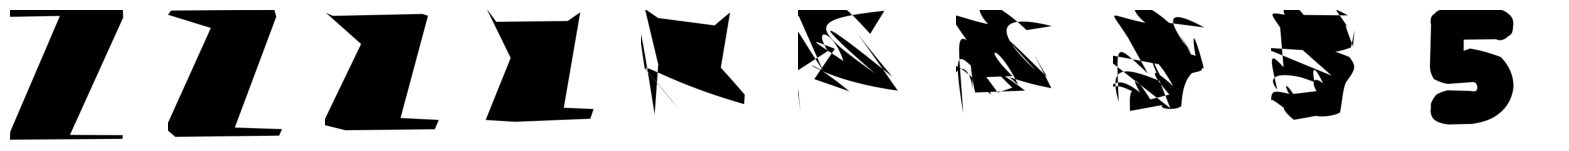

In [18]:
imgs_num = 10

# fig, ax = plt.subplots(nrows=1, ncols=10)
plt.figure(figsize=(2 * imgs_num, 5))
# plt.axis('off')

sample1, _, _ = dataset_train[2000]
sample2, _, _ = dataset_train[1897]

sample1 = encode_img(torch.Tensor([sample1]).to(device))
sample2 = encode_img(torch.Tensor([sample2]).to(device))

for ind, i in enumerate(np.linspace(0, 1, imgs_num)):
    mix = sample1 * i + sample2 * (1 - i)
    plt.subplot(1, imgs_num, ind + 1)
    plt.axis('off')
    show_sampled(to_numpy(decode_img(mix)[0]))
    
plt.show()

## Дифузионная модель

In [19]:
IMG_SIZE = 16

def show_tensor_image(image):
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = image.reshape((IMG_SIZE, IMG_SIZE))
    plt.imshow(image, cmap='gray')

In [21]:
#!g1.4
class Diffusion1:
    def __init__(self, model_inner):
        self.T = 300
        self.betas = self.linear_beta_schedule(timesteps=self.T).to(device)

        # Pre-calculate different terms for closed form
        self.alphas = (1. - self.betas)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
        self.model = model_inner
    
    @staticmethod
    def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
        return torch.linspace(start, end, timesteps)

    @staticmethod
    def get_index_from_list(vals, t, x_shape):
        """ 
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def forward_diffusion_sample(self, x_0, t):
        """ 
        Takes an image and a timestep as input and 
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0).to(device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def get_loss(self, x_0, t):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.model(x_noisy, t)
        return F.l1_loss(noise, noise_pred)
        
    @torch.no_grad()
    def sample_timestep(self, x, t):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = self.get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self.get_index_from_list(self.posterior_variance, t, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise 

    @torch.no_grad()
    def sample_plot_encoded(self):
        # Sample noise
        img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
        plt.figure(figsize=(15,15))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T // num_images)

        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = self.sample_timestep(img, t)
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize+1)
                show_tensor_image(img.detach().cpu())
        plt.show()
        
    @torch.no_grad()
    def sample_plot_image(self):
        # Sample noise
        img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T // num_images)
        
        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = self.sample_timestep(img, t)
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize+1)
                dec_img = to_numpy(decode_img(img.detach().view(1, GLIPH_WIDTH)))[0]
                show_sampled(dec_img)
        plt.show()
    
    def state_dict(self):
        return self.model.state_dict()

In [20]:
#!g1.4
class Diffusion2:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=16, device="cuda"):
        self.T = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def linear_beta_schedule(self, timesteps, start=0.0001, end=0.02):
        return torch.linspace(start, end, timesteps).to(self.device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.T, size=(n,))

    @torch.no_grad()
    def sample(self, model, n):
        model.eval()
        x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
        for i in reversed(range(1, self.T)):
            t = torch.full((n, ), i).long().to(self.device)
            predicted_noise = model(x, t)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-1, 1)
        return x
    
    @torch.no_grad()
    def sample_plot_image(self):
        # Sample noise
        img = torch.randn((1, 1, self.img_size, self.img_size), device=device)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T // num_images)
        
        
        for i in reversed(range(1, self.T)):
            t = torch.full((n, ), i).long().to(self.device)
            predicted_noise = model(x, t)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize+1)
                dec_img = to_numpy(decode_img(img.detach().view(1, GLIPH_WIDTH)))[0]
                show_sampled(dec_img)
        plt.show()

    
    def state_dict(self):
        return self.model.state_dict()

In [25]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        down_channels = (128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128)
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.lin1 = nn.Linear(256, 256)
        self.tanh = nn.Tanh()
        
        self.conv0 = nn.Conv2d(1, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i+1], time_emb_dim)
                for i in range(len(down_channels)-1)
            ]
        )
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
                for i in range(len(up_channels)-1)
            ]
        )

        self.output = nn.Conv2d(up_channels[-1], 1, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        
        x = x.view(-1, 256)
        x = self.tanh(self.lin1(x))

        x = x.view(-1, 1, 16, 16)
        x = self.conv0(x)
        
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        x = self.output(x)

        return x

model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_path = Path('models/Diffusion/ckpt.pt')
if model_path.exists():
    print('loaded from file')
    model.load_state_dict(torch.load(model_path))

model

Num params:  61763233
loaded from file


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (lin1): Linear(in_features=256, out_features=256, bias=True)
  (tanh): Tanh()
  (conv0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=512, bias=True)
      (conv1): C

## ДИФФУЗИОНКА НОМЕР 2

In [26]:
train_dataloader = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=0)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_14216\2908036427.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx // stepsize) + 1)


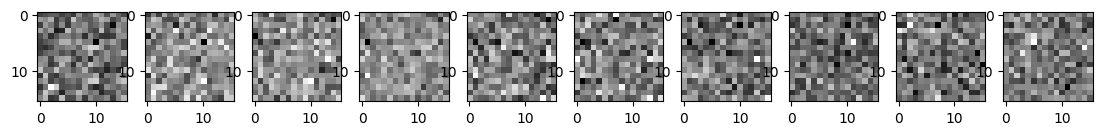

In [27]:
diffusion = Diffusion2(noise_steps=300, device=device, img_size=IMG_SIZE)

image, _, _ = dataset_test[0]

image = encode_img(torch.Tensor([image]).to(device)).view(-1, 1, IMG_SIZE, IMG_SIZE)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(diffusion.T // num_images)

for idx in range(0, diffusion.T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images+1, (idx // stepsize) + 1)
    image, noise = diffusion.noise_images(image, t)
    show_tensor_image(image.cpu().detach())

In [28]:
dif_progresser = Progresser(train_dataloader)

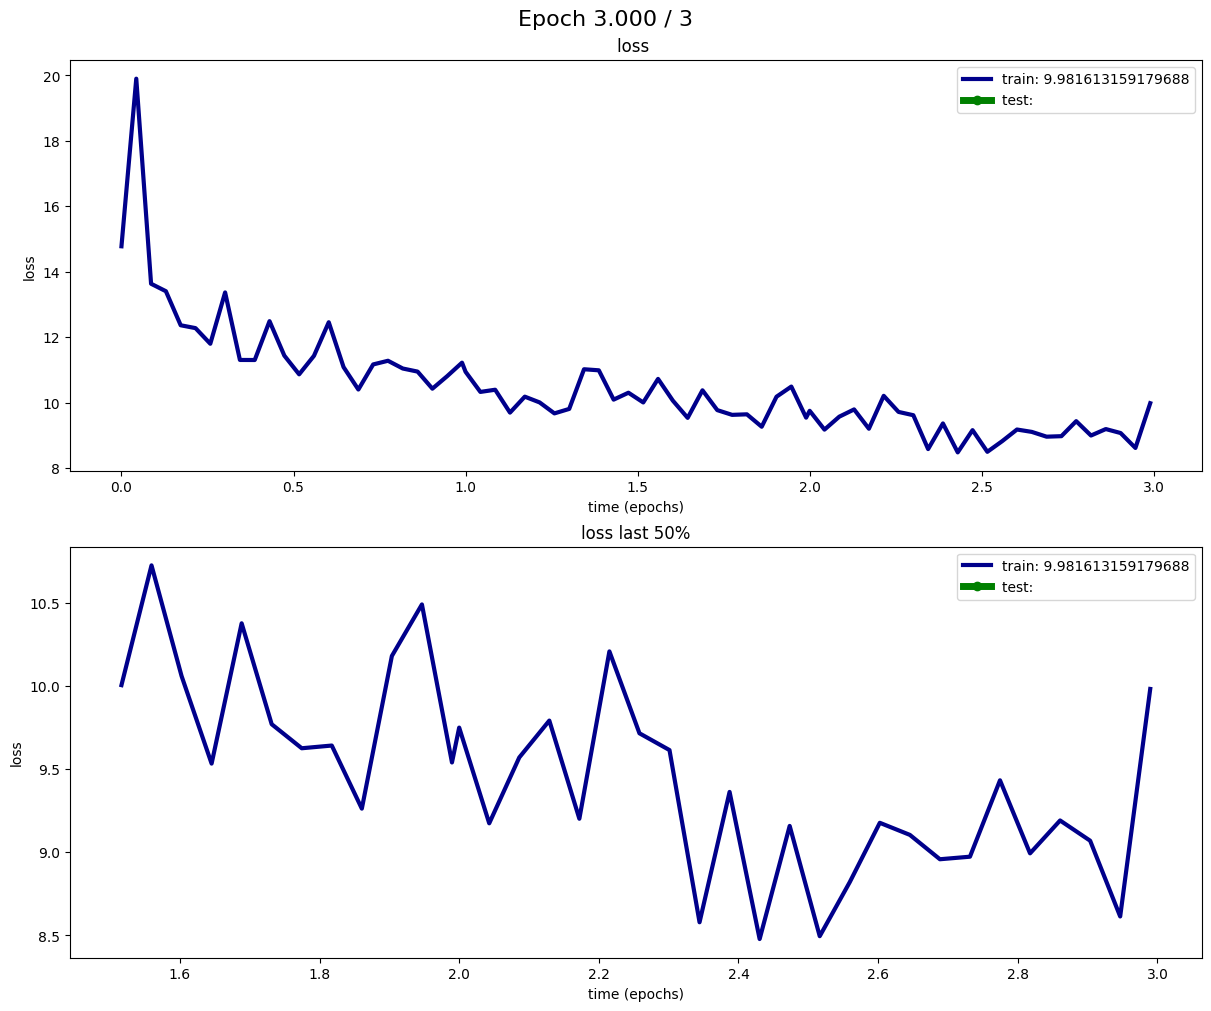

In [29]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
epochs = 3

img_per_epoch = 4
to_show_mod = len(train_dataloader) // img_per_epoch
label = torch.zeros(len(dl.GLYPH_FILTER)).to(device).view(1, -1)

save_path = Path('models/Diffusion/ckpt.pt')
save_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(0, epochs):
    pbar = tqdm(train_dataloader)
    for i, (images, _, _) in enumerate(pbar):
        images = torch.Tensor(images).to(device)
        images = encode_img(images).view(images.shape[0], 1, IMG_SIZE, IMG_SIZE)
        
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = model(x_t, t)
        loss = F.mse_loss(noise, predicted_noise, reduction='sum') / images.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(epoch=epoch, MSE=loss.item())
        if i % 50 == 0:
            dif_progresser.add_train(epoch + i / len(train_dataloader), loss.item())
        if i % to_show_mod == 0:
            sampled_images = diffusion.sample(model, n=1)
            sampled_images = sampled_images.detach().view(1, 256)

            dec_img = to_numpy(decode_img(sampled_images))[0]
            show_sampled(dec_img)
            save_sampled(dec_img, f'sample_epoch_{epoch}_step_{i}.svg')
            plt.show()
    scheduler.step()
    torch.save(model.state_dict(), save_path)
dif_progresser.show_progress(epochs, epochs)

In [25]:
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(images.to(device))
    encoded_data.append(images)
    

encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
umap_model = umap.UMAP(n_neighbors=12)
embedding = umap_model.fit_transform(encoded_data)

del encoded_data

Data shape (126663, 256)


In [32]:
sampled = diffusion.sample(model, 500)
sampled_embedding = umap_model.transform(to_numpy(sampled.view((sampled.shape[0], -1))))
noise = torch.randn_like(sampled)
noise_embedding = umap_model.transform(to_numpy(noise.view((noise.shape[0], -1))))

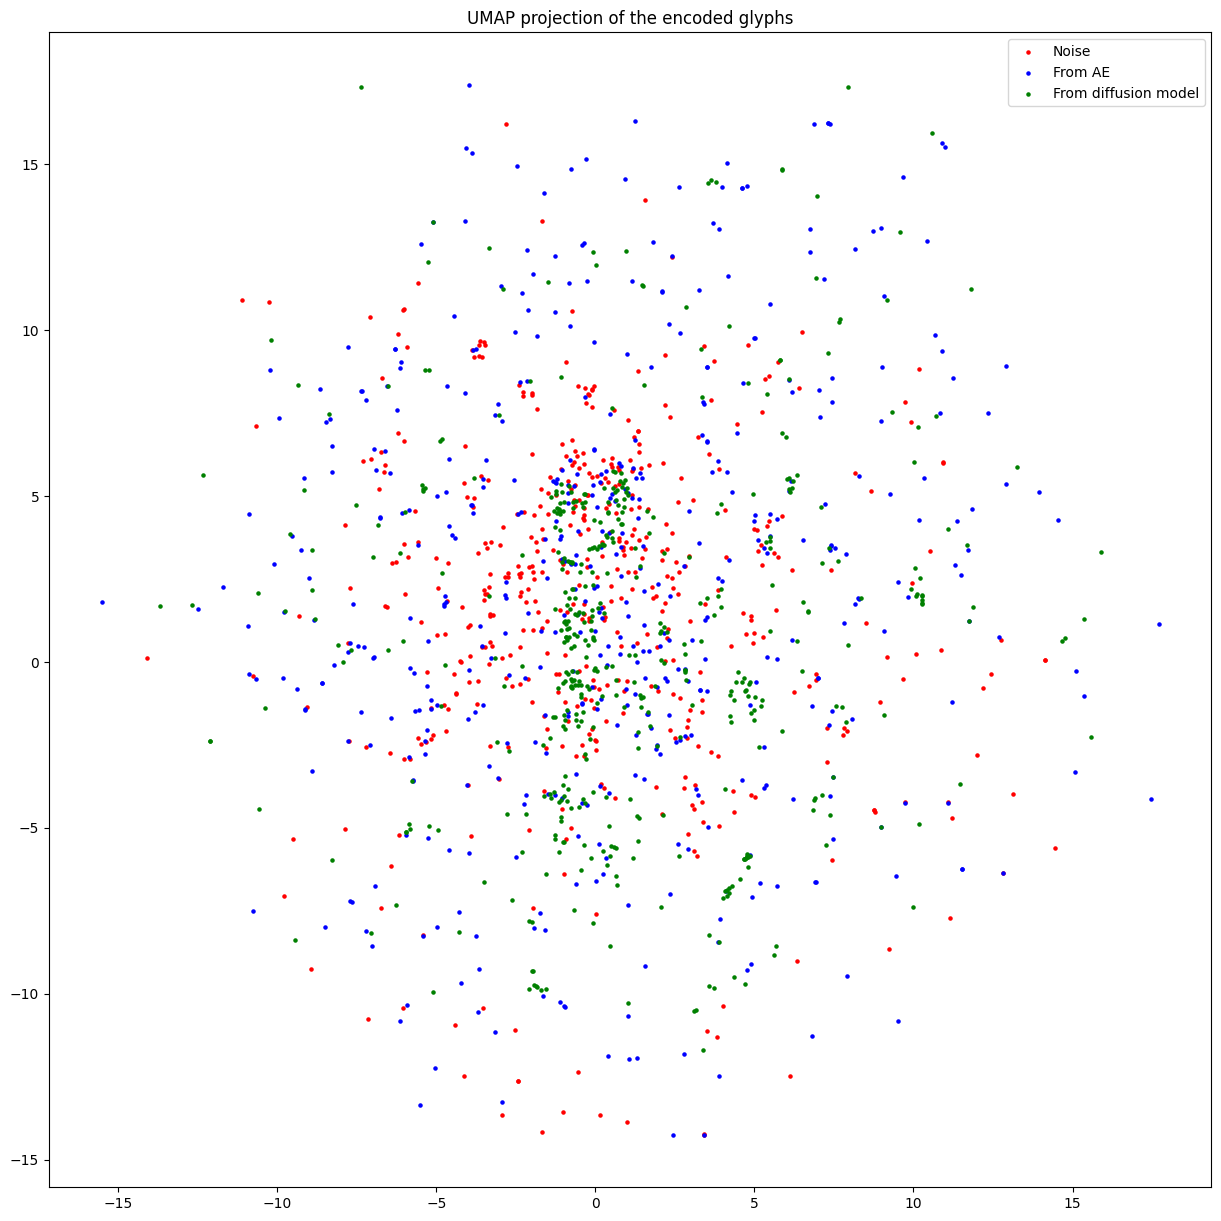

In [36]:
plt.figure(figsize=(15, 15))


plt.scatter(
    noise_embedding[:, 0], noise_embedding[:, 1], 
    c='r',
    s=5,
    label='Noise',
)
plt.scatter(
    embedding[:500, 0], embedding[:500, 1], 
    c='b',
    s=5,
    label='From AE',
)

plt.scatter(
    sampled_embedding[:, 0], sampled_embedding[:, 1], 
    c='g',
    s=5,
    label='From diffusion model',
)

plt.legend()
plt.title('UMAP projection of the encoded glyphs');
plt.show()

In [37]:
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(images.to(device))
    encoded_data.append(images)
    

encoded_data = to_numpy(torch.cat(encoded_data, 0))

In [40]:
print('max', encoded_data.max())
print('min', encoded_data.min())
print('mean', encoded_data.mean())

max 0.5450526
min -0.53985715
mean 0.0031839667


In [41]:
print('max', sampled.max())
print('min', sampled.min())
print('mean', sampled.mean())

max tensor(0.5821, device='cuda:0')
min tensor(-0.5798, device='cuda:0')
mean tensor(0.0039, device='cuda:0')


In [40]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

In [55]:
img = dataset_test[5432][0]

@interact(x=(-1,1,0.01), s=(0, 255))
def f(x=0, s=0):
    tmp = encode_img(torch.Tensor([img]).to(device))
    tmp[0][s] = x
    decoded = decode_img(tmp)
    show_sampled(to_numpy(decoded)[0])

# interact(f, x=FloatSlider(min=-1, max=1))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), IntSlider(value=0…

## ДИФФУЗИОНКА НОМЕР 1

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_7636\3963975516.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx//stepsize) + 1)


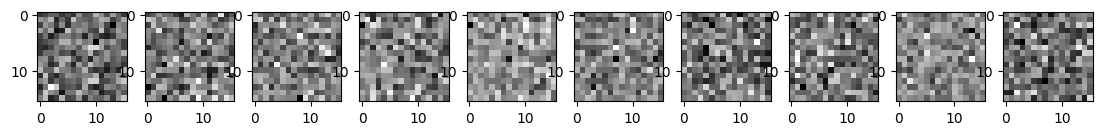

In [55]:
diffusion = Diffusion1(model)

image, _, _ = dataset_test[0]

image = encode_img(
    torch.Tensor(image.reshape((1, -1))).to(device)
).view(-1, 1, IMG_SIZE, IMG_SIZE)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(diffusion.T // num_images)

for idx in range(0, diffusion.T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    image, noise = diffusion.forward_diffusion_sample(image, t)
    show_tensor_image(image.cpu().detach())

Epoch 0 | step 000 Loss: 0.8128520846366882 


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_7636\1984477046.py:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i // stepsize+1)


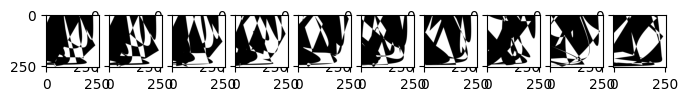

Epoch 0 | step 581 Loss: 0.13389979302883148 


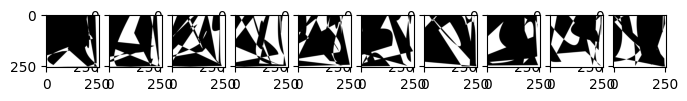

Epoch 0 | step 1162 Loss: 0.12431173771619797 


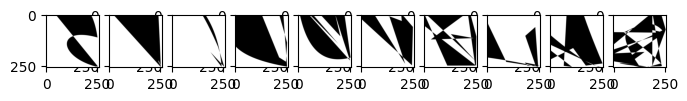

Epoch 0 | step 1743 Loss: 0.11760787665843964 


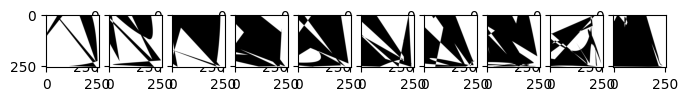

Epoch 1 | step 000 Loss: 0.11124834418296814 


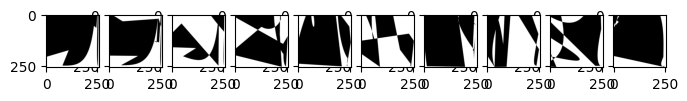

Epoch 1 | step 581 Loss: 0.12937895953655243 


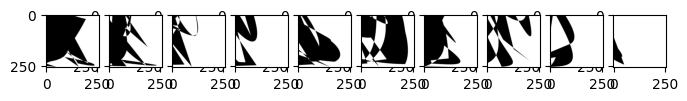

Epoch 1 | step 1162 Loss: 0.11500547081232071 


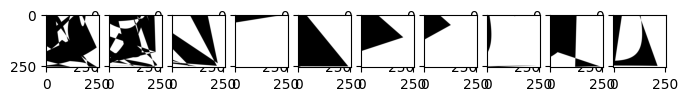

Epoch 1 | step 1743 Loss: 0.11026390641927719 


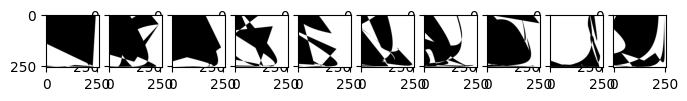

Epoch 2 | step 000 Loss: 0.10677202045917511 


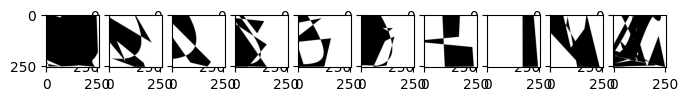

Epoch 2 | step 581 Loss: 0.10577362030744553 


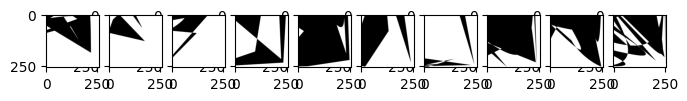

Epoch 2 | step 1162 Loss: 0.10437779873609543 


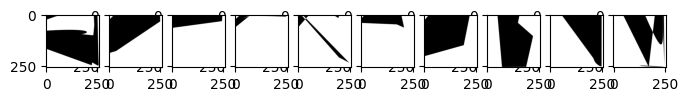

Epoch 2 | step 1743 Loss: 0.11119069159030914 


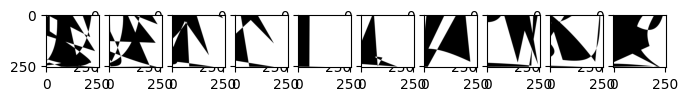

Epoch 3 | step 000 Loss: 0.10072275996208191 


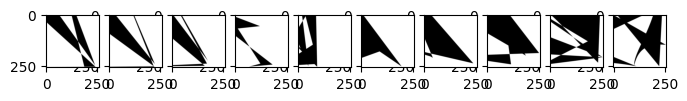

Epoch 3 | step 581 Loss: 0.10742680728435516 


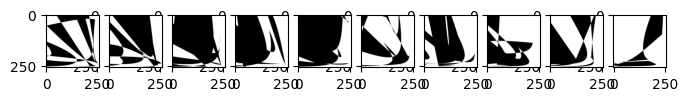

Epoch 3 | step 1162 Loss: 0.10761885344982147 


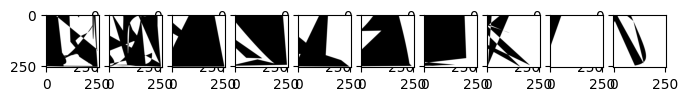

Epoch 3 | step 1743 Loss: 0.10245440900325775 


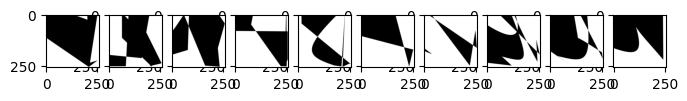

Epoch 4 | step 000 Loss: 0.10272164642810822 


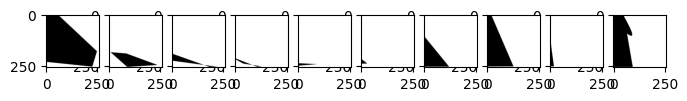

Epoch 4 | step 581 Loss: 0.1057581827044487 


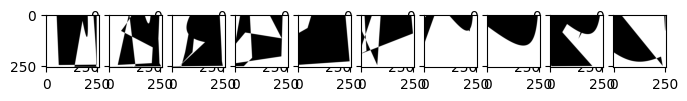

Epoch 4 | step 1162 Loss: 0.10208216309547424 


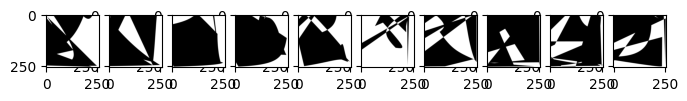

Epoch 4 | step 1743 Loss: 0.10819260776042938 


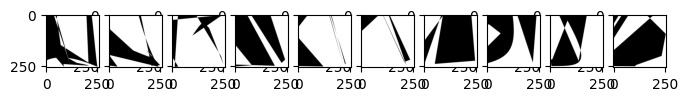

In [56]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
epochs = 5 # Try more!

img_per_epoch = 4
to_show_mod = len(train_dataloader) // img_per_epoch

for epoch in range(epochs):
    for step, (imgs, lbls, _) in enumerate(train_dataloader):
        imgs = torch.Tensor(imgs).to(device)
        # lbls = labels2one_hot(lbls).to(device)
        imgs = encode_img(imgs).view(-1, 1, IMG_SIZE, IMG_SIZE)
        
        optimizer.zero_grad()
        t = torch.randint(0, diffusion.T, (imgs.shape[0],), device=device).long().to(device)
        loss = diffusion.get_loss(imgs, t)
        loss.backward()
        optimizer.step()

        if step % to_show_mod == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            diffusion.sample_plot_image()

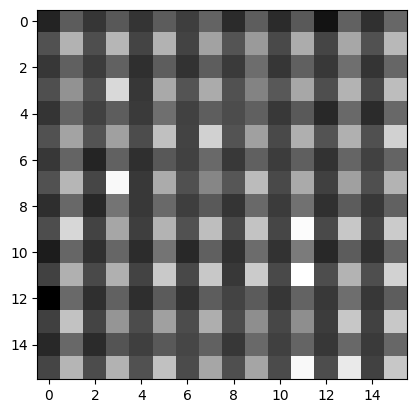

In [62]:
img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
        
for i in range(0, diffusion.T)[::-1]:
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = diffusion.sample_timestep(img, t)
show_tensor_image(img.detach().cpu())
plt.show()

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_7636\1984477046.py:105: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i // stepsize+1)


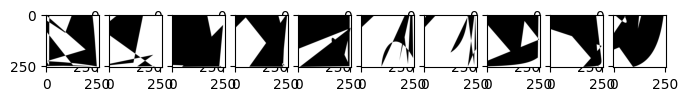

In [60]:
#!g1.4
diffusion.sample_plot_image()

In [33]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from torchvision.utils import save_image

In [38]:
model = Unet(
    dim = 16,
    dim_mults = (1, 2, 4, 8),
    channels = 1
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size=16,
    timesteps = 1000,
    objective = 'pred_v'
).to(device)

diffusion_progresser = Progresser(train_dataloader, split_num=100)

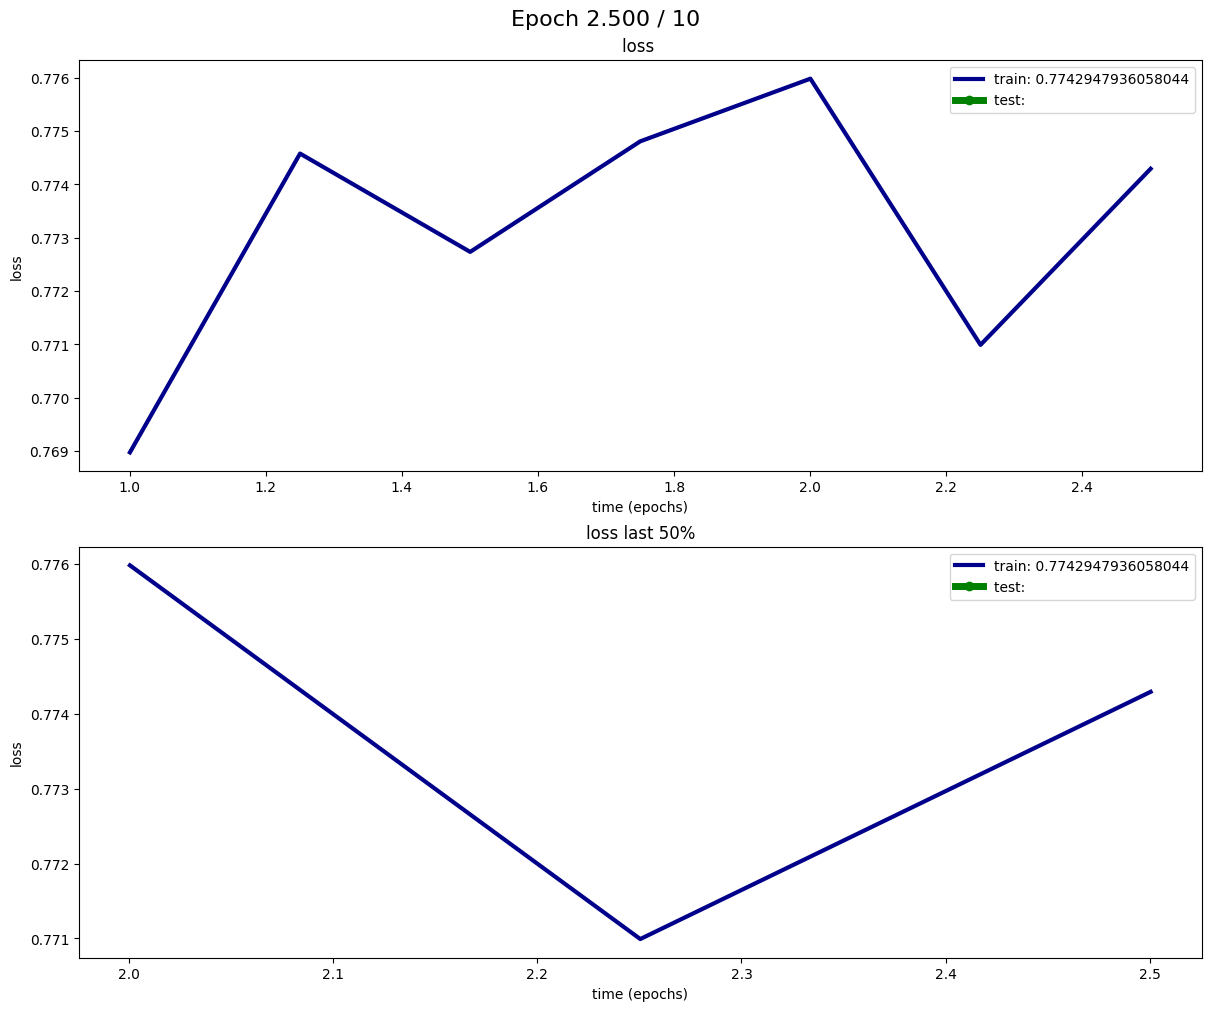

In [ ]:
num_batches = len(train_dataloader)
epochs = 10
for epoch in range(1, epochs):
    for batch, (imgs, labels, _) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        # inp_data = torch.Tensor(inp_data.to(device)
        # labels = labels2one_hot(labels).to(device)

        encoded_batch = encode_img(imgs)
        encoded_batch = encoded_batch.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
        loss = diffusion(encoded_batch)
        loss.backward()

        if batch % progresser.interval == 0:
            t = epoch + (batch + 1) / num_batches
            diffusion_progresser.add_train(t, loss.item())
            diffusion_progresser.show_progress(t, epochs)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_24396\1081733614.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, imgs_num + 1, i + 1)


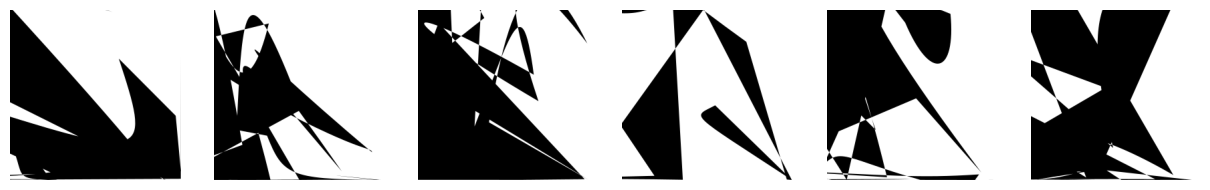

In [43]:
# after a lot of training

imgs_num = 6
plt.figure(figsize=(3 * imgs_num, 3))
plt.axis('off')

sampled_seq = diffusion.sample(batch_size = imgs_num)
a_labels = ['a'] * imgs_num
a_labels = labels2one_hot(a_labels).to(device)
decoded_images = to_numpy(decode_img(sampled_seq.reshape(imgs_num, GLIPH_WIDTH), a_labels))

for i in range(imgs_num):
    plt.subplot(1, imgs_num + 1, i + 1)
    plt.axis('off')
    show_sampled(decoded_images[i])